# Sentiment analysis
#### Description:
To learn more about NLP and more specifically the transformers architecture, we created this notebook.
The purpose of the notebook is to build a sentiment analysis model that can efficiently classify positive from negative imbd reviews. A score in line with SOTA implementations is the goal. (That plus learning) (https://paperswithcode.com/sota/sentiment-analysis-on-imdb)

#### Data:
We use the standford imbd dataset hosted on hugging face

### 1. Load packages and data

In [1]:
%pip install datasets
%pip install transformers
%pip install evaluate
%pip install tqdm
%pip install seaborn
%pip install matplotlib
%pip install scikit-learn
%pip install torch
%pip install transformers[torch]


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgr

In [2]:
import pandas as pd
import numpy as np
import tqdm as notebook_tqdm
from datasets import load_dataset
from IPython.display import display, Markdown, Latex
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from transformers import AutoTokenizer

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#download split data
train_dataset = load_dataset("stanfordnlp/imdb", split="train").to_pandas()
test_dataset  = load_dataset("stanfordnlp/imdb", split="test").to_pandas()

#### 2. EDA

The train dataset consist of 25000 rows and 2 columns. 50% of the data is labelled as positive. Very well balanced problem.

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [ ]:
train_dataset.describe()

,label
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


let's look at a few positive and negative examples

In [ ]:
positive_examples= train_dataset[train_dataset['label']==1]['text'].iloc[0:4].values
negative_examples = train_dataset[train_dataset['label']==0]['text'].iloc[0:4].values

In [ ]:
display(Markdown('\n\n'.join([f"{i+1}. {positive_examples[i]}" for i in range(0,len(positive_examples))])))

1. Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.

2. Zentropa is the most original movie I've seen in years. If you like unique thrillers that are influenced by film noir, then this is just the right cure for all of those Hollywood summer blockbusters clogging the theaters these days. Von Trier's follow-ups like Breaking the Waves have gotten more acclaim, but this is really his best work. It is flashy without being distracting and offers the perfect combination of suspense and dark humor. It's too bad he decided handheld cameras were the wave of the future. It's hard to say who talked him away from the style he exhibits here, but it's everyone's loss that he went into his heavily theoretical dogma direction instead.

3. Lars Von Trier is never backward in trying out new techniques. Some of them are very original while others are best forgotten.<br /><br />He depicts postwar Germany as a nightmarish train journey. With so many cities lying in ruins, Leo Kessler a young American of German descent feels obliged to help in their restoration. It is not a simple task as he quickly finds out.<br /><br />His uncle finds him a job as a night conductor on the Zentropa Railway Line. His job is to attend to the needs of the passengers. When the shoes are polished a chalk mark is made on the soles. A terrible argument ensues when a passenger's shoes are not chalked despite the fact they have been polished. There are many allusions to the German fanaticism of adherence to such stupid details.<br /><br />The railway journey is like an allegory representing man's procession through life with all its trials and tribulations. In one sequence Leo dashes through the back carriages to discover them filled with half-starved bodies appearing to have just escaped from Auschwitz . These images, horrible as they are, are fleeting as in a dream, each with its own terrible impact yet unconnected.<br /><br />At a station called Urmitz Leo jumps from the train with a parceled bomb. In view of many by-standers he connects the bomb to the underside of a carriage. He returns to his cabin and makes a connection to a time clock. Later he jumps from the train (at high speed) and lies in the cool grass on a river bank. Looking at the stars above he decides that his job is to build and not destroy. Subsequently as he sees the train approaching a giant bridge he runs at breakneck speed to board the train and stop the clock. If you care to analyse the situation it is a completely impossible task. Quite ridiculous in fact. It could only happen in a dream.<br /><br />It's strange how one remembers little details such as a row of cups hanging on hooks and rattling away with the swaying of the train.<br /><br />Despite the fact that this film is widely acclaimed, I prefer Lars Von Trier's later films (Breaking the Waves and The Idiots). The bomb scene described above really put me off. Perhaps I'm a realist.

4. *Contains spoilers due to me having to describe some film techniques, so read at your own risk!*<br /><br />I loved this film. The use of tinting in some of the scenes makes it seem like an old photograph come to life. I also enjoyed the projection of people on a back screen. For instance, in one scene, Leopold calls his wife and she is projected behind him rather than in a typical split screen. Her face is huge in the back and Leo's is in the foreground.<br /><br />One of the best uses of this is when the young boys kill the Ravensteins on the train, a scene shot in an almost political poster style, with facial close ups. It reminded me of Battleship Potemkin, that intense constant style coupled with the spray of red to convey tons of horror without much gore. Same with the scene when Katharina finds her father dead in the bathtub...you can only see the red water on the side. It is one of the things I love about Von Trier, his understatement of horror, which ends up making it all the more creepy.<br /><br />The use of text in the film was unique, like when Leo's character is pushed by the word, "Werewolf." I have never seen anything like that in a film.<br /><br />The use of black comedy in this film was well done. Ernst-Hugo Järegård is great as Leo's uncle. It brings up the snickers I got from his role in the Kingdom (Riget.) This humor makes the plotline of absurd anal retentiveness of train conductors against the terrible backdrop of WW2 and all the chaos, easier to take. It reminds me of Riget in the way the hospital administrator is trying to maintain a normalcy at the end of part one when everything is going crazy. It shows that some people are truly oblivious to the awful things happening around them. Yet some people, like Leo, are tuned in, but do nothing positive about it.<br /><br />The voice over, done expertly well by Max von Sydow, is amusing too. It draws you into the story and makes you jump into Leo's head, which at times is a scary place to be.<br /><br />The movie brings up the point that one is a coward if they don't choose a side. I see the same idea used in Dancer in the Dark, where Bjork's character doesn't speak up for herself and ends up being her own destruction. Actually, at one time, Von Trier seemed anti-woman to me, by making Breaking the Waves and Dancer, but now I know his male characters don't fare well either! I found myself at the same place during the end of Dancer, when you seriously want the main character to rethink their actions, but of course, they never do!

In [ ]:
display(Markdown('\n\n'.join([f"{i+1}. {negative_examples[i]}" for i in range(0,len(negative_examples))])))

1. I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno. While my countrymen mind find it shocking, in reality sex and nudity are a major staple in Swedish cinema. Even Ingmar Bergman, arguably their answer to good old boy John Ford, had sex scenes in his films.<br /><br />I do commend the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in pornographic theaters in America. I AM CURIOUS-YELLOW is a good film for anyone wanting to study the meat and potatoes (no pun intended) of Swedish cinema. But really, this film doesn't have much of a plot.

2. "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn't true. I've seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don't exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we're treated to the site of Vincent Gallo's throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, and the same cannot be said for a man. In fact, you generally won't see female genitals in an American film in anything short of porn or explicit erotica. This alleged double-standard is less a double standard than an admittedly depressing ability to come to terms culturally with the insides of women's bodies.

3. If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />

4. This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film instead.<br /><br />The film has two strong elements and those are, (1) the realistic acting (2) the impressive, undeservedly good, photo. Apart from that, what strikes me most is the endless stream of silliness. Lena Nyman has to be most annoying actress in the world. She acts so stupid and with all the nudity in this film,...it's unattractive. Comparing to Godard's film, intellectuality has been replaced with stupidity. Without going too far on this subject, I would say that follows from the difference in ideals between the French and the Swedish society.<br /><br />A movie of its time, and place. 2/10.

### 3. Preprocessing

In [ ]:
# clean the text (remove italic and so on)
def clean(text):
    text = re.sub(r'<br\s*/?>', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [ ]:
train_dataset['clean_text'] = train_dataset['text'].apply(lambda x: clean(x))


#### 3.1 Tokenization
We use scikit learn tfidf vectorizer to tokenize the text. In order to be able to see the output and understand the process.
We start by tokenizing the first string to display how it works.

In [ ]:
#tokenize the text
vectorizer_s = TfidfVectorizer(stop_words='english', max_features=5000)

In [ ]:

first_pos = positive_examples[0]
first_pos_tok  = vectorizer_s.fit_transform([first_pos])

In [ ]:
display(Markdown(first_pos))

Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.

In [ ]:
vectorizer_s.get_feature_names_out()

array(['american', 'bit', 'br', 'camera', 'coherent', 'common',
       'contrast', 'crafted', 'disjointed', 'doesn', 'dream', 'effect',
       'emotionally', 'europe', 'film', 'frightening', 'gets', 'grim',
       'innocent', 'intentional', 'intriguing', 'inventive', 'involved',
       'like', 'making', 'man', 'movie', 'naivety', 'natives',
       'nightmare', 'noir', 'postwar', 'presented', 'really', 'respect',
       'rubble', 'say', 'sees', 'sense', 'set', 'shine', 'spoil',
       'storyline', 'striking', 'sun', 'ttm', 'understand',
       'unrelentingly', 'woman', 'work', 'zentropa'], dtype=object)

In [ ]:
#visualize the tfidf matrix
# Create a DataFrame with the TF-IDF scores
df = pd.DataFrame(first_pos_tok.toarray(), columns=vectorizer_s.get_feature_names_out())

mask = df == 0

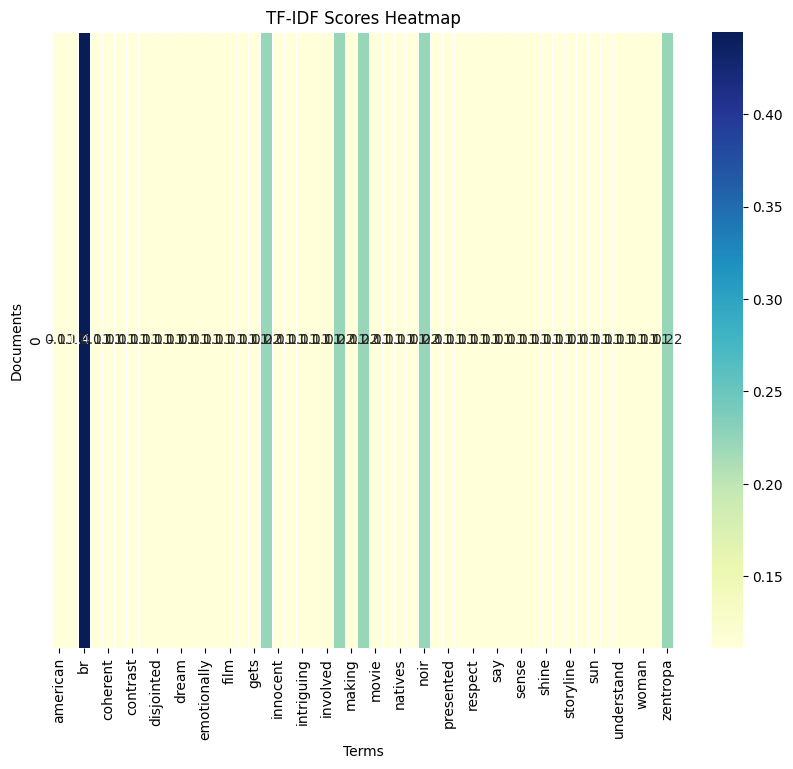

In [ ]:
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(df,mask=mask ,cmap='YlGnBu', annot=True, fmt=".2f", linewidths=.5)
plt.title('TF-IDF Scores Heatmap')
plt.xlabel('Terms')
plt.ylabel('Documents')
plt.show()

The vectorize removed punctuation and lowercased the text. It also removed stopwords.

Now let's do it for the whole dataset

In [ ]:
#tokenize the text
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
train_dataset_tokens = vectorizer.fit_transform(train_dataset['clean_text'])

## 4. Modelling

We start by training a logistic regression model to use as a baseline model to compare the transformer model to.

#### 4.1 Logistic regression

In [ ]:
logistic = LogisticRegression(max_iter=1000,penalty='l2')
logistic.fit(train_dataset_tokens, train_dataset['label'])

LogisticRegression(max_iter=1000)

In [ ]:
test_dataset['clean_text'] = test_dataset['text'].apply(lambda x: clean(x))
test_dataset_tokens = vectorizer.transform(test_dataset['clean_text'])


In [ ]:
y_pred = logistic.predict(test_dataset_tokens)
y_test = test_dataset['label']


In [ ]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.87908
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [ ]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[10930  1570]
 [ 1453 11047]]


#### 4.2 Transformers
For this, we will use bert. We will use the transformers library to load the model and tokenizer. We will then fine-tune the model on the imbd dataset.

In [25]:
train_dataset = load_dataset("stanfordnlp/imdb", split="train")
test_dataset  = load_dataset("stanfordnlp/imdb", split="test")

In [36]:
tokenizer_name= "lyeonii/bert-tiny"
model_name = "lyeonii/bert-tiny"

In [37]:
# import the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

In [38]:
print(tokenizer.model_max_length)

512


In [109]:
def preprocess_text(doc):
    if isinstance(doc, str):
         return tokenizer(doc, return_tensors='pt',padding=True, truncation=True)
    else:
        return tokenizer(doc['text'], return_tensors='pt',padding=True, truncation=True)

In [110]:
tokenized_imdb_train = train_dataset.map(preprocess_text, batched=True)
tokenized_imdb_test = test_dataset.map(preprocess_text, batched=True)

Map: 100%|██████████| 25000/25000 [00:14<00:00, 1722.19 examples/s]


In [41]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [42]:
import evaluate

accuracy = evaluate.load("accuracy")

In [43]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [44]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [46]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
   model_name, num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at lyeonii/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="best",
    load_best_model_at_end=True,
    report_to='none'
)

In [54]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb_train,
    eval_dataset=tokenized_imdb_test,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


In [55]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.335200,0.335713,0.858440
2,0.310600,0.322741,0.868000
3,0.291000,0.319018,0.866200
4,0.271600,0.316838,0.871160


TrainOutput(global_step=6252, training_loss=0.30677581977478147, metrics={'train_runtime': 2806.4394, 'train_samples_per_second': 35.632, 'train_steps_per_second': 2.228, 'total_flos': 127048704000000.0, 'train_loss': 0.30677581977478147, 'epoch': 4.0})

In [117]:
def pred_sentiment(model,text):
    inputs = preprocess_text(text)

    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = torch.nn.functional.softmax(logits,dim=1)[0]
    sentiment_idx = probabilities.argmax().item()
    conf = probabilities[sentiment_idx].item()*100
    labels ={0:"Negative", 1:"Positive"}
    return {'label':labels[sentiment_idx], 'prob':round(conf,2)}


In [ ]:
modelpath = 

In [ ]:
# load trained model 
model = AutoModelForSequenceClassification.from_pretrained(
    modelpath,
    torch_dtype=torch.bfloat16,
    device_map="cpu",
)
tokenizer = AutoTokenizer.from_pretrained(modelpath)

In [118]:
text = "This movie was absolutely fantastic!"

In [119]:
pred_sentiment(model=model,text = text)

{'label': 'Positive', 'prob': 96.55}

TypeError: Module.get_parameter() missing 1 required positional argument: 'target'